# Running Through EAZY Py

##### Made by Eddie Cunning, 2024 Honours Project

This is an individual testing notebook, testing one template suite at a time.
You choose a field, and a catalogue key, and the notebook will run through the EAZY process, outputting a variety of graphs and data.
Further, there is an agn_sed component, this is where you can select which AGN templates you want to use, and the use_galaxy_templates component, which allows you to use galaxy templates as well as AGN templates. The number valeus are as the templates appear in the file explorer, so the first template is 0, the second is 1, and so on.
catalogue_prepare.ipynb can be used to prepare a catalogue for testing.


In [18]:
%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import eazy.hdf5
import time
import importlib
import sys
import eazy
import astropy.stats
import prospect
import math

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)
print('EAZYCODE = '+ str(os.getenv('EAZYCODE')) + '\n')

print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy', 'prospect']:
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

EAZYCODE = None

Thu Aug 29 17:16:25 2024

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]

               numpy : 1.22.4
               scipy : 1.11.4
          matplotlib : 3.8.4
             astropy : 5.1
                eazy : 0.6.8
            prospect : 1.0.0


Basic Settings Cell, can find more in depth changes further down

In [3]:
# Load ZFOURGE catalogue from local drive
test_title = 'test_6' # title of the test, eg. 1,2, A, B, Initial.
field = 'cdfs' #'cdfs', 'cosmos', or 'uds'

# Choose ID key for the catalogue
# A key designates what type of test you want to occur
id_key = 'fraction0.3to0.4' # normal, high or low

# Directories for key, name keys anything, it is just to keep track of any complex object choices made in catalogue_prepare.ipynb
id_key_dict = {
    'normal': f'inputs/alternate_catalogues/{field}.normal.cat',
    'fraction0.0to0.1': f'inputs/alternate_catalogues/{field}.fraction.bin0.0to0.1.cat',
    'fraction0.1to0.2': f'inputs/alternate_catalogues/{field}.fraction.bin0.1to0.2.cat',
    'fraction0.2to0.3': f'inputs/alternate_catalogues/{field}.fraction.bin0.2to0.3.cat',
    'fraction0.3to0.4': f'inputs/alternate_catalogues/{field}.fraction.bin0.3to0.4.cat',
    'fraction0.4to0.5': f'inputs/alternate_catalogues/{field}.fraction.bin0.4to0.5.cat',
    'ir_agn': f'inputs/alternate_catalogues/{field}.ir_agn.cat',
    'radio_agn': f'inputs/alternate_catalogues/{field}.radio_agn.cat',
    'xray_agn': f'inputs/alternate_catalogues/{field}.xray_agn.cat',
    'only_agn_0.4': f'inputs/alternate_catalogues/{field}.only_agn_above_0.4.cat',
    'only_agn_0.5': f'inputs/alternate_catalogues/{field}.only_agn_above_0.5.cat',
    'lacy': f'inputs/alternate_catalogues/{field}.lacy_wedge.cat',
    'donley': f'inputs/alternate_catalogues/{field}.donley_wedge.cat',
    'useflag': f'inputs/alternate_catalogues/{field}.useflag.cat'
}
# AGN templates allocation
loop_number = 1 # what loop you are on, however in the test ipy this is not used
agn_sed = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40] # AGN templates to be added, comma separated list
#agn_sed = []
use_galaxy_templates = False # set to True to use galaxy templates as well

In [4]:
# finding/creating the output directories
output_location = 'G:/honours/outputs'
# Directories
if not os.path.isdir(f'{output_location}/{field}/{test_title}'):
    os.makedirs(f'{output_location}/{field}/{test_title}')

# Where to Save number data
output_directory = f'{output_location}/{field}/{test_title}/{field}_{test_title}_{id_key}_{agn_sed}_{use_galaxy_templates}' # output directory for images
key_data_file = f'{output_location}/{field}/{test_title}/{test_title}_data.csv'
headings = ['id_key', 'zstep', 'loop_number', 'agn_templates', 'galaxy templates', 'total_obj', 'mean_agn_frac', 'spec_count', 'outlier_count', 'nmad_val']

key_data = pd.DataFrame(columns=headings)
if not os.path.isfile(key_data_file):
    key_data.to_csv(key_data_file, index=False)


Loading Templates Function

In [16]:
# Load any templates from the AGN template library

temp_param = 'templates/eazy_v1.3.spectra.param' # basic parameter file, no agn templates
last_id = 9 # last id in the parameter file
empty_param = 'templates/eazy_v1.3_empty.param' # empty parameter file
agn_param = 'templates/eazy_v1.3_AGN.param' # parameter file with agn templates

# opening the parameter files, and reading the contents
with open(temp_param) as f:
    original_galaxy = f.read()

with open(empty_param) as f:
    original_empty = f.read()

agn_dir = 'templates/hlsp_agnsedatlas_rest/' # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)


def agn_template_loader(templates, use_galaxy_templates=True):

    """
    Function to load AGN templates to the parameter file
    templates: list of templates to be added
    use_galaxy_templates: set to True to use galaxy templates as well
    """
    if use_galaxy_templates:
        copy_original_galaxy = original_galaxy
        no_of_templates_added = len(templates)
        if no_of_templates_added == 0:
            open(agn_param, 'w').write(copy_original_galaxy)
            print('No AGN templates added, just using EAZY galaxy templates')
            return
        for i in range(no_of_templates_added):
            current_id = last_id + 1 + i
            copy_original_galaxy = copy_original_galaxy + f'\n{current_id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
        open(agn_param, 'w').write(copy_original_galaxy)
        print(f'AGN templates added to the parameter file, {templates}, {agn_param}, {last_id} galaxy templates used')
        return
    else:
        copy_original_galaxy = original_empty
        no_of_templates_added = len(templates)
        if no_of_templates_added == 0:
            open(agn_param, 'w').write(copy_original_galaxy)
            print('No AGN templates added, no Galaxy templates used')
            return
        for i in range(no_of_templates_added):
            current_id = 1 + i
            copy_original_galaxy = copy_original_galaxy + f'\n{current_id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
        open(agn_param, 'w').write(copy_original_galaxy)
        print(f'AGN templates added to the parameter file {agn_param}, no galaxy templates used')
        return


AGN Data Analysis

(0.01, 1000.0)

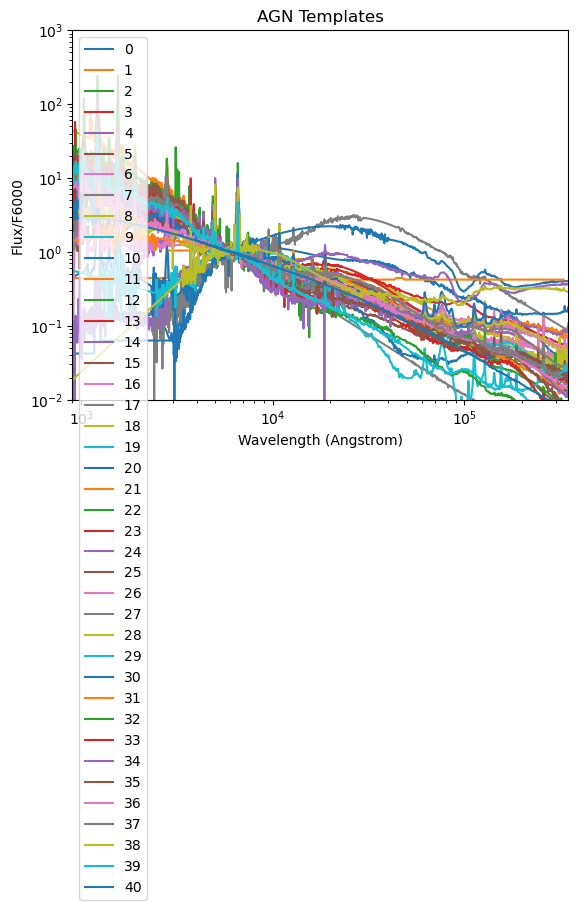

In [6]:
#plotting all the templates used
plt.clf()
for i in range(len(agn_sed)):
    template_data = pd.read_csv(f'{agn_dir}{agn_temp_all[agn_sed[i]]}', sep=' ', header=None)
    flux_position =  abs(template_data[0] - 6000).idxmin()
    flux_normal = template_data[1][flux_position]
    plt.plot(template_data[0], template_data[1] / flux_normal, label=f'{agn_sed[i]}')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux/F6000')
plt.title('AGN Templates')
plt.xlim(900, 35e4)
plt.ylim(1e-2, 1e3)


In [77]:
# Read the catalogue
os.getcwd()

main_cat = pd.read_csv(id_key_dict[id_key]) # get the catalogue for the id_key
main_cat.to_csv('inputs/eazy_test.cat', index=False) # create a new catalogue, allows for change to be made in this cell

#Setting up the main catalogue
main = pd.read_csv('inputs/eazy_test.cat', sep=" ", comment="#", header=None, skipinitialspace=True) # opening cut cat, and adjusting it
headers = pd.read_csv('inputs/eazy_test.cat', sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers

total_count = len(main) # all objects in the range
total_count

2795

In [78]:
# Plot of % influence from AGN on each object

agn_per_dir = f'inputs/{field}_agn_frac.txt' # file with AGN fractions for each object, prepared in catalogue_prepare.ipynb
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

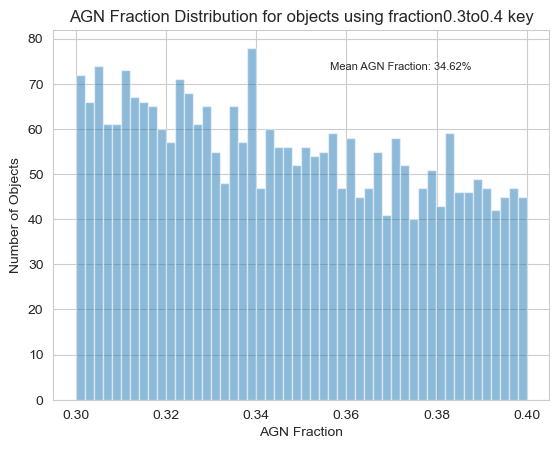

In [79]:
has_fraction = 'bayes.agn.fracAGN' in main.columns
if not has_fraction:
    main = pd.merge(main, all_bayes, on='id', how='left') # AGN fraction for each object

mean_frac = np.mean(main['bayes.agn.fracAGN'])

plt.clf()
plt.hist(main['bayes.agn.fracAGN'], bins=50, alpha=0.5, label='AGN Fraction')

plt.xlabel('AGN Fraction')
plt.ylabel('Number of Objects')
plt.title(f'AGN Fraction Distribution for objects using {id_key} key')
plt.text(0.7, 0.9, f'Mean AGN Fraction: {mean_frac:.2%}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig(f'{output_location}/{field}/{test_title}/agn_frac_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Running EAZY, some parameters can be changed here, look to the base.param file to adjust more

In [10]:
# EAZY parameters

# following files should be in the same dir as the project
param_file = 'base.param' #base parameter file, does not include all information
translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate')

agn_template_loader(agn_sed, use_galaxy_templates=use_galaxy_templates) # loads the chosen AGN templates to the parameter file

params = {} # setting field specific parameters
params['Z_STEP'] = 0.05 # redshift step, defines the precision of each fit, 0.005 default

#inputs
params['TEMPLATES_FILE'] = agn_param # parameter file containing which templates will be used
params['CACHE_FILE'] = f'{output_location}/{field}/{test_title}/tempfilt_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.dat' # template cache file, not used
params['CATALOG_FILE'] = 'inputs/eazy_test.cat' # for cut catalogue created in the earlier cell
params['TEMPLATE_COMBOS'] = 1 #1 single template fit 2 pairs of templates as defined in templates file −2 all pair combinations or a for all, it is a as defult
params['APPLY_PRIOR'] = 'y' # apply the prior, y as default
#outputs
params['MAIN_OUTPUT_FILE'] = output_directory # output directory set earlier


AGN templates added to the parameter file templates/eazy_v1.3_AGN.param, no galaxy templates used


Initialize eazy.photoz.PhotoZ object

In [81]:
# Run EAZY with parameters

self = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file[0], zeropoint_file=None,
                         params=params, load_prior=True, load_products=False)

Read default param file: base.param
Read CATALOG_FILE: inputs/eazy_test.cat
   >>> NOBJ = 2795
f_IRAC_80 e_IRAC_80 ( 21): IRAC/irac_tr4_2004-08-09.dat
f_IRAC_58 e_IRAC_58 ( 20): IRAC/irac_tr3_2004-08-09.dat
f_IRAC_45 e_IRAC_45 ( 19): IRAC/irac_tr2_2004-08-09.dat
f_IRAC_36 e_IRAC_36 ( 18): IRAC/irac_tr1_2004-08-09.dat
f_Ks e_Ks (255): FOURSTAR/Ks_cam_optics_sky.txt
f_KsHI e_KsHI (269): VLT/hawki_k_ETC.dat
f_J1 e_J1 (249): FOURSTAR/J1_cam_optics_sky.txt
f_J2 e_J2 (250): FOURSTAR/J2_cam_optics_sky.txt
f_J3 e_J3 (251): FOURSTAR/J3_cam_optics_sky.txt
f_Hs e_Hs (254): FOURSTAR/Hshort_cam_optics_sky.txt
f_Hl e_Hl (253): FOURSTAR/Hlong_cam_optics_sky.txt
f_U e_U (103): ESO/vimos_u.res
f_B e_B (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_V e_V (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_I e_I (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_Z e_Z (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_F140W e_F140W (204)

100%|██████████| 1/1 [00:12<00:00, 12.42s/it]


Template   0: hlsp_agnsedatlas_multi_multi_2masxj13000533+1632151_multi_v1_spec-rest.dat (NZ=1).
Process templates: 13.562 s


48it [00:00, 513.24it/s]


Iterative zeropoint corrections

In [ ]:
# Iterative Zero-point corrections

NITER = 3 # no. of iterations
NBIN = np.minimum(self.NOBJ//100, 180) # no. of bins

for iter in range(NITER):
    print('Iteration: ', iter)

    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False,
                              update_zeropoints=True, iter=iter, n_proc=8,
                              save_templates=False, error_residuals=False,
                              NBIN=NBIN, get_spatial_offset=False)

Iteration:  0


100%|██████████| 48/48 [00:04<00:00, 10.54it/s]


Compute best fits


Now fit the whole catalog

In [ ]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

# Show zspec-zphot comparison
zmax = 8
fig = self.zphot_zspec(zmax = zmax)
fig.savefig(f'{output_location}/{field}/{test_title}/zphot_zspec_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')

In [ ]:
# Derived parameters (z params, RF colors, masses, SFR, etc.)
# produces a linAlg Error occasionally, wasn't needed anyway
# warnings.simplefilter('ignore', category=RuntimeWarning)
# zout, hdu = self.standard_output(simple=False,
#                                  rf_pad_width=0.5, rf_max_err=2,
#                                  prior=True, beta_prior=True,
#                                  absmag_filters=[],
#                                  extra_rf_filters=[])

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

UVJ Plots

In [ ]:
# Show UVJ diagram
# see comment in above cell
# uv = -2.5*np.log10(zout['restU']/zout['restV'])
# vj = -2.5*np.log10(zout['restV']/zout['restJ'])
# ssfr = zout['sfr']/zout['mass']
#
# sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
# plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel],
#             vmin=-13, vmax=-8, alpha=0.5, cmap='RdYlBu')
#
# #plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
# plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')

Array Showing Worst Fits, Used in Graphing

In [ ]:
all_zphot_zspec = pd.DataFrame({'id':self.idx, 'zspec':self.ZSPEC, 'zphot':self.zbest, 'agn_fraction':main['bayes.agn.fracAGN']})
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zspec'] > 0.005] #setting minimums for the redshifts
all_zphot_zspec = all_zphot_zspec[all_zphot_zspec['zphot'] > 0.02]
all_zphot_zspec['compare'] = (all_zphot_zspec['zphot'] - all_zphot_zspec['zspec']) / ( 1 + all_zphot_zspec['zspec'])


Colour Colour

In [ ]:
#Colour Plot with each template (maybe a range around them), and then each object plotted, to see how well these templates cover the objects, in the observed frame

colours = ['IRAC_36', 'IRAC_45', 'IRAC_58', 'IRAC_80'] # colours to be used, dictates loops and filter responses
columns = ['id', 'agn_fraction', 'red_diff'] + colours # columns to be used in the dataframe
used_colours = pd.DataFrame(columns=columns)

for i in range(len(colours)):
    used_colours[colours[i]] = main[f'f_{colours[i]}']

used_colours['id'] = main['id']
used_colours['agn_fraction'] = main['bayes.agn.fracAGN']
used_colours['red_diff'] = all_zphot_zspec['compare']

no_negative_mask = ~used_colours[colours].lt(0).any(axis=1)
used_colours = used_colours[no_negative_mask] #remove -99 values

used_colours['x'] = np.log10(used_colours['IRAC_58']/used_colours['IRAC_36'])
used_colours['y'] = np.log10(used_colours['IRAC_80']/used_colours['IRAC_45'])
#Template colours

filters_values = {'IRAC_36': 35569, 'IRAC_45': 45020, 'IRAC_58': 57450, 'IRAC_80': 79158}

def template_colour_redshift(template, redshift):
    """
    Function to calculate the colours of a template at a given redshift
    template: template number
    redshift: redshift of the object
    """

    template_data_pre = pd.read_csv(f'{agn_dir}{agn_temp_all[template]}', sep=' ', header=None)

    template_data_shifted = pd.DataFrame(columns=['wavelength', 'flux'])
    template_data_shifted['wavelength']= (redshift * template_data_pre[0]) + template_data_pre[0] #redshifting the template
    template_data_shifted['flux'] = template_data_pre[1]

    temp_filt_flux_all = pd.DataFrame(columns=[colours])

    for j in range(len(colours)):
        # finds what flux best correlates with the wavelength pivot of the given filter
        min_location = abs(template_data_shifted['wavelength'] - filters_values[colours[j]]).idxmin()
        temp_filt_flux = template_data_shifted['flux'][min_location]
        temp_filt_flux_all[colours[j]] = [temp_filt_flux]

    return temp_filt_flux_all

In [ ]:
# IRAC plot
import matplotlib.colors as colors

plt.clf()
three_sig_limit = used_colours['red_diff'].std(ddof=3)
norm = colors.Normalize(vmin=-three_sig_limit, vmax=three_sig_limit)

plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['red_diff'], cmap='PiYG', norm=norm, marker='.', alpha=0.9)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with Redshift Difference')

# Plot Lacy Lines
x_boundary = np.linspace(-0.1, 2, 100)  # Adjust range as needed
y_boundary1 = -0.2 * np.ones_like(x_boundary)
y_boundary2 = 0.8 * x_boundary + 0.5
y_line = np.linspace(-0.2, 0.4, 100)
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')

# Define functions for boundary lines
def line1(x):
    return 1.21 * x - 0.27
def line2(x):
    return 1.21 * x + 0.27

# Generate x values for plotting lines
x_values1 = np.linspace(0.08, max(used_colours['x']), 100)
x_values2 = np.linspace(0.35, max(used_colours['x']), 100)

# Plot the lines
plt.plot(x_values2, line1(x_values2), color='magenta', linestyle='--')
plt.plot(x_values1, line2(x_values1), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.35, 10), np.linspace(0.15, 0.15, 10), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.08, 10), np.linspace(0.15, 0.35, 10), color='magenta', linestyle='--')

In [ ]:
# IRAC plot
plt.clf()
plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['agn_fraction'], cmap='inferno', marker='.', alpha=0.5)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with AGN Fraction')

# Plot the lines
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')
plt.plot(x_values2, line1(x_values2), color='magenta', linestyle='--')
plt.plot(x_values1, line2(x_values1), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.35, 10), np.linspace(0.15, 0.15, 10), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.08, 10), np.linspace(0.15, 0.35, 10), color='magenta', linestyle='--')

In [ ]:
# PLot With Template Colours shown
plt.clf()
plt.scatter(used_colours['x'], used_colours['y'], c=used_colours['agn_fraction'], cmap='inferno', marker='.', alpha=0.5)
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)
plt.colorbar()

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('IRAC Plot with AGN Fraction')

templates_graph = agn_sed # templates to be plotted
redshift_graph = np.linspace(0, 5, 50) # redshifts to be plotted
for i in range(len(templates_graph)):
    for j in range(len(redshift_graph)):
        temp_redshift = template_colour_redshift(templates_graph[i], redshift_graph[j])
        temp_redshift.to_numpy()
        temp_redshift['x_axis'] = np.log10(used_colours['IRAC_58']/used_colours['IRAC_36'])
        temp_redshift['y_axis'] = np.log10(used_colours['IRAC_80']/used_colours['IRAC_45'])
        plt.plot(temp_redshift['y_axis'], temp_redshift['x_axis'],marker='o', c='green')




Redshift Plot with AGN fraction

In [ ]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['zphot'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 6], 'r--')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT')
plt.title('ZSPEC vs ZPHOT with AGN Fraction')
plt.colorbar()


RedShift Difference Vs AGN Fraction

In [ ]:
plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=all_zphot_zspec['agn_fraction'], cmap='inferno', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with AGN Fraction')

In [ ]:
# see how many filters objects are present in
filter_count = [sum(self.fnu[object_id] <= 0) for object_id in all_zphot_zspec['id']]

plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=filter_count, cmap='ocean', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with No. of Filters')

## Binned Graphs

In [ ]:
# see filter error
import matplotlib.colors as colors
all_filter_error = pd.DataFrame(self.efnu).replace(99, np.nan, inplace=False)
filter_error = [np.mean(all_filter_error.loc[object_id, :]) for object_id in all_zphot_zspec['id']]

plt.clf()
plt.scatter(all_zphot_zspec['zspec'],
            all_zphot_zspec['compare'],
            c=filter_error,
            norm=colors.LogNorm(vmin=min(filter_error), vmax=max(filter_error)),
            cmap='summer', alpha=0.9, label='AGN Fraction')
plt.plot([0, 6], [0, 0], 'r--')

three_sig_limit = all_zphot_zspec['compare'].std(ddof=3)
plt.plot([0, 6], [three_sig_limit, three_sig_limit], c='b', ls=(0, (5, 10)))
plt.plot([0, 6], [-three_sig_limit, -three_sig_limit], c='b', ls=(0, (5, 10)))
#plt.xlim(0, 6)
#plt.ylim(-0.8, 0.8)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
plt.title('Redshift Difference with Average Filter Error')

In [ ]:
max(filter_error)

In [ ]:
main['ZSPEC'] = self.ZSPEC; main['ZPHOT'] = self.zbest # adding zspec and zphot to the agn_frac df
main['chi2'] = self.chi2_best / self.NFILT # adding chi2/N to the main df

#sort main df by zspec
main_red = main[main['ZSPEC'] > 0] # filter
main_red = main_red[main_red['ZPHOT'] > 0.02] # filter
main_red = main_red[main_red['ZSPEC'] <= 6] # filter
main_red = main_red.sort_values(by='ZSPEC') # sort

#sort main df by agn fraction
main_agn = main_red.dropna(subset=['bayes.agn.fracAGN']) # filter
main_agn = main_agn.sort_values(by='bayes.agn.fracAGN') # sort

#total NMAD
zspec_nmad = np.array(main_red['ZSPEC'])
zphot_nmad = np.array(main_red['ZPHOT'])
dz = (zphot_nmad - zspec_nmad) / (1 + zspec_nmad)
total_nmad = astropy.stats.mad_std(dz)
print(f'Total NMAD: {total_nmad}')

#outliers
spec_count = len(dz)
catastrophic_limit = 0.15 # catastrophic_limit in eazy code
outliers = np.abs(dz) >= catastrophic_limit
outliers_count = sum(outliers)
print(f'Total Outliers:{outliers_count}')

In [ ]:
quick_test = 1

In [ ]:
# worst fits
worst_fits = abs(all_zphot_zspec['compare'])
worst_fits = worst_fits.sort_values(ascending=True)
worst_fits.head(20)

In [ ]:
no_of_bins = 15 # no. of bins
logbins_start = np.log10(min(main_red['ZSPEC'])) # using logarithmic bins
logbins_end = np.log10(max(main_red['ZSPEC'])) + 1e-10 # adding a small value to include the last value
logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins+1)
counts_red, bins_red = np.histogram(main_red['ZSPEC'], bins=logbins)
print(f'Counts: {counts_red}')
print(f'Total: {len(main_red["ZSPEC"])}')
bin_centers_red = (np.array(bins_red[:-1]) + np.array(bins_red[1:])) / 2

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_red_val = []
outlier_frac_red = []
chi2_red = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_red[bin_loop]-1
    zspec_val = main_red['ZSPEC'][last_val:new_val]
    zphot_val = main_red['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_red_val.append(astropy.stats.mad_std(dz)) # NMAD
    outliers_bin = np.abs(dz) >= catastrophic_limit
    bin_fraction = sum(outliers_bin) / counts_red[bin_loop]
    outlier_frac_red.append(bin_fraction)
    chi2_med = np.median(main_red['chi2'][last_val:new_val]) # chi2
    chi2_red.append(chi2_med)
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_red_val}')
print(f'Outliers: {outlier_frac_red}')
print(f'Fits: {chi2_red}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_red, nmad_red_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_red, outlier_frac_red, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_red, chi2_red, 'm--')
ax[2].set_xlabel('Redshift')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

plt.savefig(f'{output_location}/{field}/{test_title}/RED_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

In [ ]:
#NMAD against AGN fraction

counts_agn, bins_agn = np.histogram(main_agn['bayes.agn.fracAGN'], bins=no_of_bins)
print(f'Counts: {counts_agn}')
bin_centers_agn = (np.array(bins_agn[:-1]) + np.array(bins_agn[1:])) / 2

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_agn_val = []
outlier_frac_agn = []
chi2_agn = []
for bin_loop in range(no_of_bins):
    new_val = last_val + counts_agn[bin_loop]-1
    zspec_val = main_agn['ZSPEC'][last_val:new_val]
    zphot_val = main_agn['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_agn_val.append(astropy.stats.mad_std(dz)) # NMAD
    outliers_bin = np.abs(dz) >= catastrophic_limit # outlier
    bin_fraction = sum(outliers_bin) / counts_agn[bin_loop]
    outlier_frac_agn.append(bin_fraction)
    chi2_med = np.median(main_agn['chi2'][last_val:new_val]) # chi2
    chi2_agn.append(chi2_med)
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin

print(f'NMAD: {nmad_agn_val}')
print(f'Outliers: {outlier_frac_agn}')
print(f'Fits: {chi2_agn}')

plt.clf()
fig, ax = plt.subplots(3, 1, sharex=True)

# NMAD
ax[0].plot(bin_centers_agn, nmad_agn_val, 'r--')
ax[0].set_ylabel('NMAD')
ax[0].text(0.25, 3.2, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Outliers
ax[1].plot(bin_centers_agn, outlier_frac_agn, 'b--')
ax[1].set_ylabel('Outlier Fraction')

# Chi2
ax[2].plot(bin_centers_agn, chi2_agn, 'm--')
ax[2].set_xlabel('AGN Fraction')
ax[2].set_ylabel('Chi2')

fig.tight_layout()

plt.savefig(f'{output_location}/{field}/{test_title}/AGN_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

## Chi 2 Graphs

In [ ]:
# Chi 2 against Spectroscopic Redshift
main_chi2 = main_red
main_chi2['compare'] = (main_chi2['ZPHOT'] - main_chi2['ZSPEC']) / (1 + main_chi2['ZSPEC']) # redshift difference

plt.clf()
three_sig_limit = main_chi2['compare'].std(ddof=3)
norm = colors.Normalize(vmin=-three_sig_limit, vmax=three_sig_limit)

plt.scatter(main_chi2['ZSPEC'], main_chi2['chi2'], c=main_chi2['compare'], cmap='PiYG',norm=norm, alpha=0.5)
plt.colorbar()
plt.xlabel('ZSPEC')
plt.ylabel('Chi2')
plt.yscale('log')
plt.title('Chi2 vs ZSPEC with Redshift Difference')

In [ ]:
no_of_bins = 20
bin_edges = pd.qcut(main_chi2['chi2'], no_of_bins)
bin_edges = bin_edges.cat.categories
chi2_bins = np.zeros([no_of_bins, 3])
for i in range(no_of_bins):
    min_loop = bin_edges[i].left
    max_loop = bin_edges[i].right
    bin_values = main_chi2[(main_chi2['chi2'] >= min_loop) & (main_chi2['chi2'] <= max_loop)]
    chi2_bins[i, 0] = sum(bin_values['compare'] >= catastrophic_limit) / len(bin_values) # outlier fraction (outliers / total)
    chi2_bins[i, 1] = np.std(bin_values['chi2'])**2 # chi2 variance
    chi2_bins[i, 2] = np.mean(bin_values['chi2']) # chi2 mean

fig,(ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(main_chi2['chi2'], main_chi2['compare'], marker='.', alpha=0.5)
ax1.plot([0, max(main_chi2['chi2'])], [0, 0], 'k--')
#ax1.ylabel('ZPHOT - ZSPEC / (1 + ZSPEC)')
ax1.set_ylim(-0.5, 0.5)
ax1.set_title('Chi2 vs Redshift Difference')

ax2.plot(chi2_bins[:, 2], chi2_bins[:, 0], 'r--', label='Outlier Fraction')
ax2.plot(chi2_bins[:, 2], chi2_bins[:, 1] / max(chi2_bins[:, 1]), 'b--', label='Chi2 Variance')
ax2.legend()
ax2.set_xlabel('Chi2')
ax2.set_xscale('log')

## Redshift Vs AGN Fraction

In [ ]:
delta_z = (np.array(main_agn['ZPHOT']) - np.array(main_agn['ZSPEC'])) / (1 + np.array(main_agn['ZSPEC']))
red_agn_plot = pd.DataFrame(columns=['delta_z', 'agn_fraction'])
red_agn_plot['delta_z'] = delta_z
agn_fraction = main_agn['bayes.agn.fracAGN']
agn_fraction.index = range(len(agn_fraction))
red_agn_plot['agn_fraction'] = agn_fraction
red_agn_plot = red_agn_plot.sort_values(by=['agn_fraction'])
#red_agn_plot = red_agn_plot[abs(red_agn_plot['delta_z']) <= catastrophic_limit]

no_of_bins_red_agn = 30
bin_edges = pd.qcut(red_agn_plot['agn_fraction'], no_of_bins_red_agn)
bin_edges = bin_edges.cat.categories
red_agn_bins = np.zeros([no_of_bins_red_agn, 2])

for i in range(no_of_bins_red_agn):
    min_loop = bin_edges[i].left
    max_loop = bin_edges[i].right
    bin_values = red_agn_plot[(red_agn_plot['agn_fraction'] >= min_loop) & (red_agn_plot['agn_fraction'] <= max_loop)]
    red_agn_bins[i, 0] = np.mean(bin_values['delta_z'])
    red_agn_bins[i, 1] = np.mean(bin_values['agn_fraction'])

In [ ]:
plt.clf()
plt.scatter(red_agn_plot['agn_fraction'], red_agn_plot['delta_z'], alpha=0.5)
plt.plot(red_agn_bins[:, 1], red_agn_bins[:, 0], 'r--')
plt.ylim(-0.5, 0.5)
plt.xlabel('AGN Fraction')
plt.ylabel('Zp - Zs /(1+Zs)')
plt.title('Redshift vs AGN Fraction')

Residuals

In [ ]:
#limit the no of objects to those that are present in all bands, and have a positive redshift
flux_observed = []
flux_residual_objects = []

# Filter section
filter_attendance = 39 # can miss 1 filter and still be selected
for i in range(len(self.fnu)):
    if self.ZSPEC[i] < 0.001:
        continue
    if sum(self.fnu[i] <= 0) > filter_attendance:
        continue # don't use objects where more than filter attendance filters are missing (eg. if one filter_attendance is 1, if one filter is missing it still goes forward, if two are missing it doesn't)
    else:
        flux_observed.append(self.fnu[i])
        flux_residual_objects.append(i)
flux_observed = np.array(flux_observed)

#find the residuals of the objects
flux_model = self.fmodel[flux_residual_objects]
error_observed = self.efnu[flux_residual_objects]
flux_residual = np.zeros_like(flux_observed)
residual_uncertainties = []
for row in range(len(flux_residual_objects)):
    residual_uncertainties.append(error_observed[row] / flux_observed[row])
    for col in range(flux_observed.shape[1]): #no. of bands
        if flux_observed[row,col] == -99: # if the flux is -99, it is not recorded and should not be shown as such
            flux_residual[row, col] = math.nan
        elif flux_model[row,col] == 0: # some models have no flux, this means they will be removed later
            flux_residual[row, col] = math.nan
        else:
            flux_residual[row,col] = (flux_observed[row,col] - flux_model[row,col]) / flux_observed[row,col]

#flux_residual = flux_residual[~np.isnan(flux_residual).any(axis=1)] # remove nan values
residual_uncertainties = np.array(residual_uncertainties)

#redshift the objects
object_redshifted = []
pivots = self.pivot
for i in range(len(flux_residual_objects)):
    im = flux_residual_objects[i]
    redshifted = pivots / (1 + self.ZSPEC[im])
    object_redshifted.append(redshifted)
object_redshifted = np.array(object_redshifted)

In [ ]:
pd.DataFrame(flux_model).describe()

In [ ]:
#plot the residuals
wavelength_flat = object_redshifted.flatten()
residual_flat = flux_residual.flatten()
uncertainties_flat = residual_uncertainties.flatten()

#binning
obj_per_bin = round(0.5 * sum(self.ZSPEC > 0.001)) #EAZY used 2000
res_sorted = pd.DataFrame({'wavelength':wavelength_flat, 'residual':residual_flat, 'uncertainties':uncertainties_flat})
res_sorted = res_sorted.sort_values(by='wavelength')
res_sorted = res_sorted.dropna(how='any') # remove nan
res_std = np.std(res_sorted['residual'])
res_sorted = res_sorted[abs(res_sorted['residual']) < 3 * res_std] # remove 3sig outliers
no_of_bins_res = np.ceil(len(res_sorted) // obj_per_bin)
res_sorted = res_sorted.reset_index(drop=True)
res_sorted_copy = res_sorted # not abs
res_sorted = abs(res_sorted)
res_bin = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", "Confidence"])
res_bin_copy = pd.DataFrame(columns=["Median Residuals", "Median Wavelength", "Median Uncertainties", 'Confidence'])
for i in range(int(no_of_bins_res)):
    min_loop = i * obj_per_bin
    max_loop = ((i+1) * obj_per_bin)
    med_res = np.median(res_sorted['residual'][min_loop:max_loop])
    med_res_copy = np.median(res_sorted_copy['residual'][min_loop:max_loop]) # only the residuals should be affected by abs
    med_wave = np.median(res_sorted['wavelength'][min_loop:max_loop])
    med_unc = np.median(res_sorted['uncertainties'][min_loop:max_loop])
    confidence =  (50/68.2) * 1.2533 * (np.std(res_sorted_copy['residual'][min_loop:max_loop])/np.sqrt(obj_per_bin)) # want 50% confidence interval from standard error of the median
    res_bin.loc[i] = [med_res, med_wave, med_unc, confidence]
    res_bin_copy.loc[i] = [med_res_copy, med_wave, med_unc, confidence] # copy is not abs, used in plot with negative values

In [ ]:
res_sorted.describe()

In [ ]:
plt.clf()
fig, ax = plt.subplots(2, 1, sharex=True)
fig.gca().set_xscale('log')
fig.gca().xaxis.set_major_formatter('{x:.0f}')

ax[0].plot(wavelength_flat, residual_flat, 'k,', alpha=0.1)
ax[0].plot(res_bin_copy["Median Wavelength"], res_bin_copy["Median Residuals"], 'r')
ax[0].fill_between(res_bin_copy["Median Wavelength"],
                 res_bin_copy["Median Residuals"] - res_bin["Confidence"],
                 res_bin_copy["Median Residuals"] + res_bin["Confidence"], alpha=0.2, color='orange')
ax[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
ax[0].set_ylim(-0.2, 0.2)
ax[0].set_xlim(1e3, 6e4)
ax[0].set_ylabel('F-T/F')
ax[0].set_title(f'Residuals of the objects at Restframe for {id_key} in {field} with {agn_sed}')

ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Residuals"], 'r', label='Absolute Residuals')
# ax[1].plot(res_bin["Median Wavelength"], res_bin["Median Uncertainties"], 'b-.', label='Uncertainties')
ax[1].plot(res_bin["Median Wavelength"], res_bin["Confidence"], 'k-.', label='Confidence')
ax[1].set_ylim(0, 0.3)
ax[1].set_ylabel('Median Residuals')
ax[1].set_xlabel('Wavelength (Angstrom)')
ax[1].legend()

fig.tight_layout()

#plt.savefig(f'{output_location}/{field}/{test_title}/residuals_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Saving Key data to csv and h5

In [ ]:
induvidual_data = pd.DataFrame(columns=['id', 'phot_redshift', 'chi2'])
induvidual_data['id'] = self.idx
induvidual_data['phot_redshift'] = self.zbest
induvidual_data['chi2'] = self.chi2_best
for i in range(self.fmodel.shape[1]):
    induvidual_data[f'band_{i}'] = self.fmodel[:,i]
induvidual_data.to_csv(f'{output_location}/{field}/{test_title}/induvidual_data_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.csv', index=False)

In [ ]:
key_data = pd.DataFrame(columns=headings)
key_data.loc[0] = [id_key, params['Z_STEP'], loop_number, agn_sed, use_galaxy_templates, total_count, mean_frac, spec_count, outliers_count, total_nmad]
key_data.to_csv(key_data_file, mode='a', index=False, header=False)

In [ ]:
eazy.hdf5.write_hdf5(self, h5file=output_directory + '.h5')

In [ ]:
# These are template independent, and are only saved from template auto reload. Use the whole cat when saving these, just steals what EAZY makes really. Eazy formats from highest wavelength to lowest, and to be consistent i just copy that.
spec_data = pd.DataFrame(columns=['id', 'zspec'])
spec_data['id'] = self.idx
spec_data['zspec'] = self.ZSPEC

filter_data = pd.DataFrame(columns=['filter', 'pivot'])
filter_data['filter'] = self.filters
filter_data['pivot'] = self.pivot

flux_data = pd.DataFrame()
for i in range(self.fnu.shape[1]):
    flux_data[f'f_band_{i}'] = self.fnu[:,i]
    flux_data[f'e_band_{i}'] = self.efnu[:,i]

# Uncomment if you want to change these files
#spec_data.to_csv(f'{output_location}/{field}/spec_data.csv', index=False)
#filter_data.to_csv(f'{output_location}/{field}/filter_data.csv', index=False)
#flux_data.to_csv(f'{output_location}/{field}/flux_data.csv', index=False)
